In [4]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

result_label = "logs_0816_tableinvariant_variations"

logs_dir_list = [os.path.join(d,os.listdir(d)[0],'default_100') for d in os.listdir('.') if d.startswith(result_label)]
logs_dir_list.sort()

In [5]:
categories = {'real_only','real_and_gpt','gpt_only','gpt_valid'}

colors_by_category = {
    'real_only': '#a4133c',
    'real_and_gpt': '#40916c',
    'gpt_only': '#0077b6',
    'gpt_valid': '#dddddd',
}

colors_by_variation = {
    'gpt_only_split_0': '#03045e',
    'gpt_only_split_1': '#0077b6',
    'gpt_only_split_2': '#00b4d8',
    'gpt_only_split_3': '#90e0ef',
    'gpt_only_split_4': '#caf0f8',
    'gpt_valid_split_6': '#005f73',
    'real_and_gpt_split_0': '#1b4332',
    'real_and_gpt_split_1': '#40916c',
    'real_and_gpt_split_2': '#74c69d',
    'real_and_gpt_split_3': '#b7e4c7',
    'real_and_gpt_split_4': '#0077b6',
    'real_and_gpt_split_5': '#00b4d8',
    'real_and_gpt_split_6': '#90e0ef',
    'real_only_split_0': '#590d22',
    'real_only_split_1': '#800f2f',
    'real_only_split_2': '#a4133c',
    'real_only_split_3': '#c9184a',
    'real_only_split_4': '#ff4d6d',
    'real_only_split_5': '#ff758f',
    'real_only_split_6': '#ffb3c1',
}

KeyError: 'gpt_valid_all'

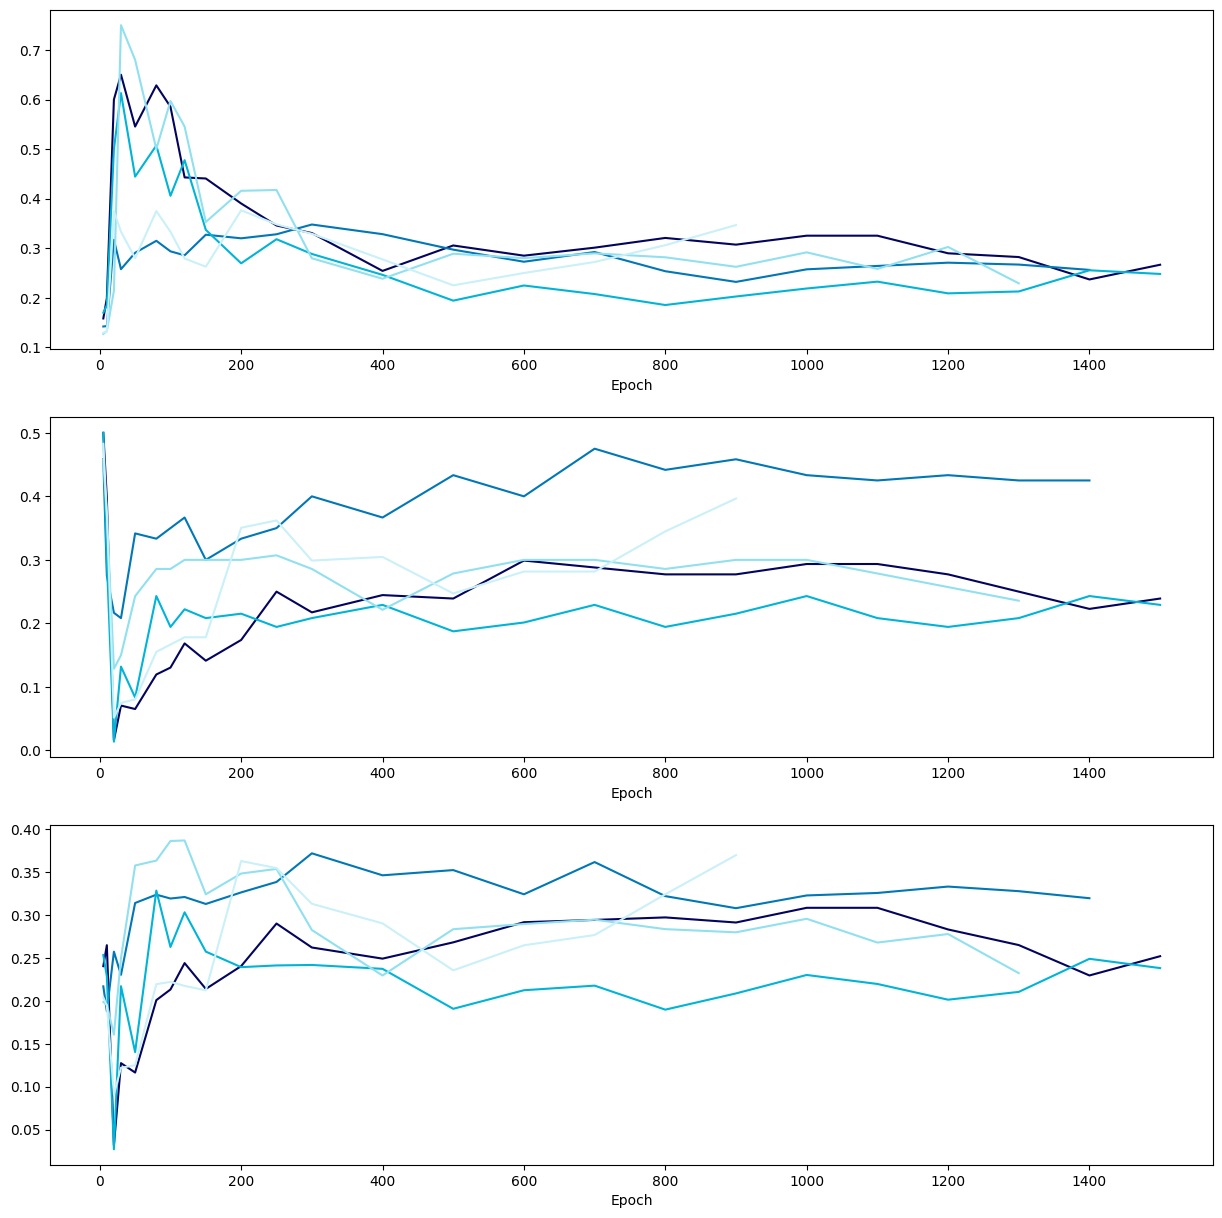

In [6]:
config = json.load(open(os.path.join(logs_dir_list[0], 'config.json')))

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
results = {'precision': {c:{ep:[] for ep in config['epochs']} for c in categories}, 
           'recall': {c:{ep:[] for ep in config['epochs']} for c in categories}, 
           'f1': {c:{ep:[] for ep in config['epochs']} for c in categories},
           'num_movements': {c:{ep:[] for ep in config['epochs']} for c in categories}}
axs = {key: axs[i] for i, key in enumerate([k for k in results.keys() if k not in ['epochs', 'num_movements']])}

for logs_dir in logs_dir_list:
    category = [c for c in categories if c in logs_dir.split('/')[-2]][0]
    results_each = {
                    'epochs': [],
                    'precision': [], 
                    'recall': [], 
                    'f1': []}
    for epoch in config['epochs']:
        json_file = os.path.join(logs_dir, f'Epoch{epoch}_test_evaluation_splits.json')
        if not os.path.exists(json_file): 
            if epoch < 110:
                print(f'{json_file} does not exist')
            continue
        with open(json_file, 'r') as f:
            data = json.load(f)
        results_each['epochs'].append(epoch)
        for key in results_each.keys():
            if key == 'epochs': continue
            results_each[key].append(data[key])
            results[key][category][epoch].append(data[key])
        results['num_movements'][category][epoch].append(data['confusion_matrix']['tp']+data['confusion_matrix']['fp'])

    labelname = logs_dir.split('/')[-2]
    for key in results_each.keys():
        if key == 'epochs': continue
        axs[key].plot(results_each['epochs'], results_each[key], label=labelname, color=colors_by_variation[labelname])
        axs[key].set_xlabel('Epoch')

for key in results.keys():
    if key in ['epochs', 'num_movements']: continue
    axs[key].legend(loc='lower right')
    axs[key].set_title(key)
fig.tight_layout()
fig.show()

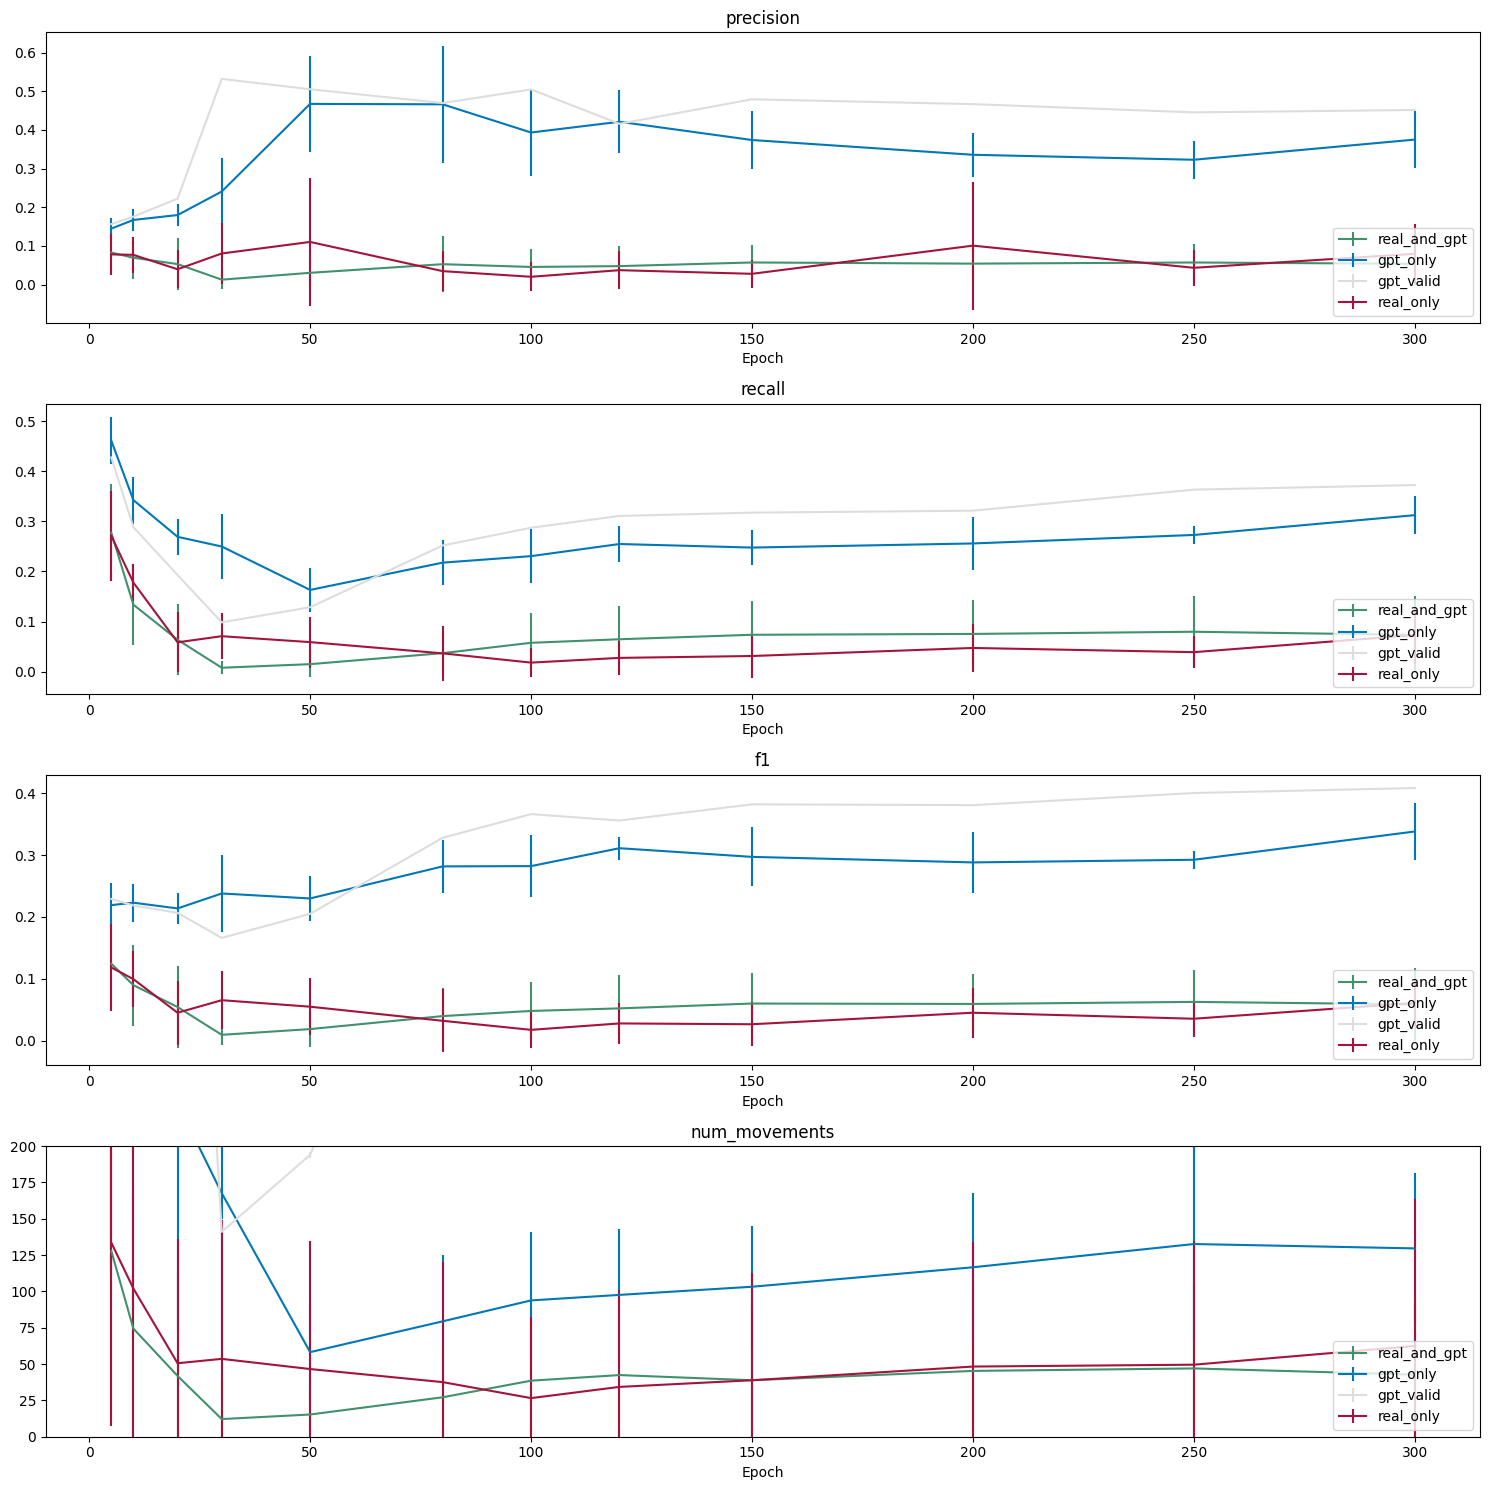

In [ ]:
fig, axs = plt.subplots(len(results.keys()), 1, figsize=(15, 15))
axs = {key: axs[i] for i, key in enumerate([k for k in results.keys()])}

for key in results.keys():
    for category in categories:
        val_mean_std = [(np.mean(vals),np.std(vals)) for vals in results[key][category].values()]
        axs[key].errorbar(results[key][category].keys(), [v[0] for v in val_mean_std], yerr=[v[1] for v in val_mean_std], label=category, color=colors_by_category[category])
    axs[key].set_xlabel('Epoch')

for key in results.keys():
    axs[key].legend(loc='lower right')
    axs[key].set_title(key)

axs['num_movements'].set_ylim(0, 200)

plt.tight_layout()
plt.show()

fig.savefig(f'figure_{result_label}.png')

plt.close()